<img src="statsmodels.png">

## ¿Qué es Statsmodels?

**Statsmodels** es un módulo de Python que proporciona clases y funciones para la estimación de muchos modelos estadísticos diferentes, así como para realizar pruebas estadísticas y exploración de datos estadísticos. Hay disponible una lista extensa de estadísticas de resultados para cada estimador. Los resultados se prueban con los paquetes estadísticos existentes para garantizar que sean correctos. El paquete se publica bajo la licencia BSD modificada de código abierto (3 cláusulas). La documentación en línea está alojada en statsmodels.org.

La principal diferencia con respecto a la implementación de regresión lineal que presenta Scikit Learn es que este paquete nos da mucha más información estadística sobre el modelo. Esto permite hacer un análisis mucho más profundo sobre el mismo y hacer una validación correcta. 

Por otro lado, las fórmulas se pueden especificar al estilo del lenguaje de programación R, aunque pueden usarse también objetos NumPy. No obstante en este cuaderno haremos uso de la primera nomenclatura. La ventaja es que para las variables categóricas no tenemos que hacer la codificación nosotros por ejemplo con Pandas (get_dummies). Nosotros especificamos la formula con la variable objetivo y las variables explicativas que queremos utilizar, y la librería se encarga del resto.

En este cuaderno vamos a utilizar una base de datos sobre peces y el objetivo sera generar un modelo de regresión lineal para predecir el peso de los peces.

In [1]:
import pandas as pd
import numpy as np
# importamos la función OLS con la cual generaremos los modelos
from statsmodels.api import OLS
# esta función nos permite especificar la fórmula como en R
from patsy import dmatrices  
# necesitamos esta función para analizar los residuos 
from statsmodels.graphics.gofplots import ProbPlot
# función para separar set entrenamiento - testeo
from sklearn.model_selection import train_test_split
# función para seleccionar las variables que mejor rendimiento dan al modelo
from sklearn.feature_selection import RFECV
# algoritmo que usaremos dentro de RFECV
from sklearn.linear_model import LinearRegression
# métrica para medir la bondad del modelo
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')
import os



In [2]:
# importamos la base de datos de coches
csv_path = os.path.join(os.getcwd(), '..', 'datasets', 'Fish', 'fish.csv')
fish_df = pd.read_csv(csv_path)
fish_df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [3]:
# obtenemos un resumen de las variables, sus tipos y los valores nulos
fish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


Las variables length hacen referencia a:
- Length1: Longitud vertical
- Length2: Longitud diagonal
- Lenght3: Longitud vertical

In [4]:
# Separamos el set de entrenamiento y set de testeo
train, test = train_test_split(fish_df, test_size = 0.2, random_state = 42)


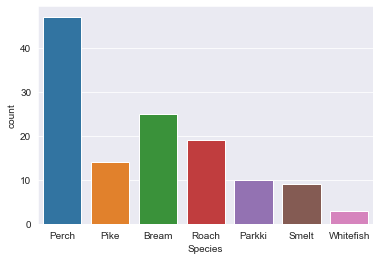

In [5]:
# vemos cuales son los valores de las especies:
sns.countplot(train['Species']);

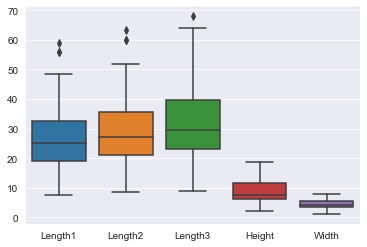

In [6]:
# Vemos los outiliers de las potenciales variables explicativas
sns.boxplot(data = train[['Length1', 'Length2', 'Length3', 'Height', 'Width']])

In [7]:
#Quitamos los outliers de la base de datos de entrenamiento
#Length1
IQR = train['Length1'].quantile(0.75) - train['Length1'].quantile(0.25)
lower_threshold = train['Length1'].quantile(0.25) - (1.5 * IQR)
upper_threshold = train['Length1'].quantile(0.75) + (1.5 * IQR)
train = train.loc[(train['Length1'] >= lower_threshold) & (train['Length1'] <= upper_threshold)]

#Length3
IQR = train['Length2'].quantile(0.75) - train['Length2'].quantile(0.25)
lower_threshold = train['Length2'].quantile(0.25) - (1.5 * IQR)
upper_threshold = train['Length2'].quantile(0.75) + (1.5 * IQR)
train = train.loc[(train['Length2'] >= lower_threshold) & (train['Length2'] <= upper_threshold)]

#Length3
IQR = train['Length3'].quantile(0.75) - train['Length3'].quantile(0.25)
lower_threshold = train['Length3'].quantile(0.25) - (1.5 * IQR)
upper_threshold = train['Length3'].quantile(0.75) + (1.5 * IQR)
train = train.loc[(train['Length3'] >= lower_threshold) & (train['Length3'] <= upper_threshold)]



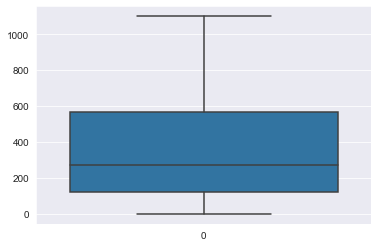

In [8]:
# vemos los outliers de la variable dependiente
sns.boxplot(data = train['Weight']);

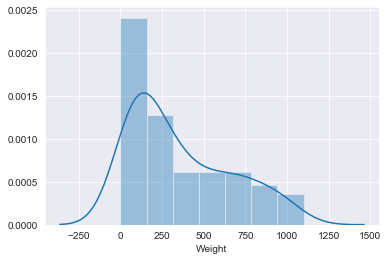

In [9]:
sns.distplot(train['Weight'])

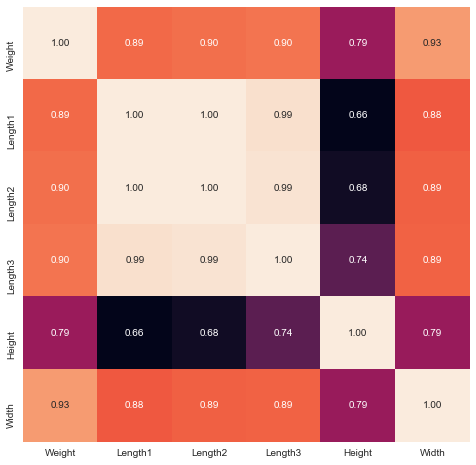

In [10]:
# nos da el indice de correlacion de pearson de las variables numéricas 
matriz_correlacion = train.corr(method = 'pearson')   

# si tienes dudas sobre esto, echa un vistazo al tutorial de seaborn donde lo explico
figure = plt.figure(figsize = (8,8))
sns.heatmap(matriz_correlacion, fmt = '.2f', annot = True, cbar = False);

Nuestra variable objetivo es **weight**. Vemos que las variables con las que contamos en nuestra base de datos presentan una muy buena correlación lineal con **weight**.

Vamos a seleccionar las variables explicativas del modelo mediante el uso del algoritmo **stepwise**. Es un proceso iterativo en el que va añadiendo o quitando variables en cada iteración a un modelo según una determinada métrica. En este caso se usa AIC. En cada paso se contempla tanto añadir como quitar variables, siempre y cuando se mejore la métrica en cuestión. A continuación se comenta línea por línea lo que se hace por pasos.

In [11]:

def stepwise(data, response):
    '''
    data: conjunto completo de datos
    response: la variable dependiente
    '''
    # Creamos un set (conjunto con valores unicos) con todas las caracteríticas a evaluar y quitamos la variable dependiente
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = float('inf'), float('inf')
    
    while True:
        #bandera para gestionar la salida del bucle
        changed = False
        #forward step
        scores_with_candidates = []
        # Recorremos cada uno de los valores que aún existen en remaining
        # Para cada uno de ellos, entrenamos el modelo y guardamos la metrica que se desee (en este caso aic) 
        for candidate in remaining:
            formula = "{} ~ {}".format(response,
                                           ' + '.join(selected + [candidate]))
            y, x = dmatrices(formula, data)
            score = OLS(y, x).fit().aic
            scores_with_candidates.append((score, candidate))
        # Ordenamos de mayor a menor
        scores_with_candidates.sort(reverse = True)
        # Nos quedamos con la mejor opción, es decir la que tiene el valor más bajo
        best_new_score_forward, best_candidate = scores_with_candidates.pop()

        #backward step
        if len(selected) > 1:
            scores_with_candidates = []
            for candidate in selected:
                variables_aux = selected.copy()
                variables_aux.remove(candidate)
                formula = "{} ~ {}".format(response, ' + '.join(variables_aux))
                y, x = dmatrices(formula, data)
                score = OLS(y, x).fit().aic
                scores_with_candidates.append((score, candidate))
            # Ordenamos de menor a mayor
            scores_with_candidates.sort()
            # Nos quedamos con la peor opcion, es decir la que tiene el valor más alto
            worst_score, worst_candidate = scores_with_candidates.pop()

            # Primero comprobamos que el peor valor no es peor que lo que tenemos actualmente
            # damos prioridad a quitar variables antes que añadir nuevas
            if current_score > worst_score:
                selected.remove(worst_candidate)
                remaining.append(worst_candidate)
                current_score = worst_score
                continue
        # En caso de que el nuevo valor sea inferior que el almacenado actualmente, lo guardamos como seleccionado y
        # actualizamo el mejor valor
        if current_score > best_new_score_forward:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score_forward
            continue
        # En caso de que no se añada ni se quite ninguna variable salimos del bucle
        break
    return selected


In [12]:
variables_seleccionadas = stepwise(train, 'Weight')
print(variables_seleccionadas)

['Width', 'Species', 'Height', 'Length1']


Una vez tenemos la variables que mejor rendimiento dan al modelo de regresión para este dataset en particular vamos a entrenar el modelo y ver un resumen estadístico del mismo:

In [13]:

# definimos la formula
formula = f"Weight ~ {' + '.join(variables_seleccionadas)}"

y, x = dmatrices(formula, train)

# entrenamos el modelo
modelo = OLS(y, x).fit()

# obtenemos un resumen detallado
modelo.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
==========================================================================
Model:                  OLS                Adj. R-squared:       0.937    
Dependent Variable:     Weight             AIC:                  1432.7130
Date:                   2020-10-25 18:47   BIC:                  1460.9158
No. Observations:       124                Log-Likelihood:       -706.36  
Df Model:               9                  F-statistic:          205.4    
Df Residuals:           114                Prob (F-statistic):   4.00e-66 
R-squared:              0.942              Scale:                5648.0   
--------------------------------------------------------------------------
                       Coef.   Std.Err.    t    P>|t|    [0.025    0.975] 
--------------------------------------------------------------------------
Intercept            -725.9860  77.1590 -9.4090 0.0000 -878.8374 -573.1347
Species[T.Parkki]      84.9062  41.7762  2.0324 0.0444    2.1479  167.6646
Species[T.Perch]      172.9839  78.4111  2.2061 0.0294   17.6522  328.3157
Species[T.Pike]       143.9672 129.1137  1.1150 0.2672 -111.8060  399.7404
Species[T.Roach]      124.3011  71.9416  1.7278 0.0867  -18.2147  266.8169
Species[T.Smelt]      409.6124  87.8782  4.6611 0.0000  235.5263  583.6985
Species[T.Whitefish]  121.7878  79.5865  1.5303 0.1287  -35.8724  279.4480
Width                  57.8980  22.0915  2.6208 0.0100   14.1348  101.6611
Height                 40.1494  13.2118  3.0389 0.0029   13.9768   66.3219
Length1                13.3373   4.5101  2.9572 0.0038    4.4028   22.2718
--------------------------------------------------------------------------
Omnibus:                 27.278          Durbin-Watson:             1.694 
Prob(Omnibus):           0.000           Jarque-Bera (JB):          42.694
Skew:                    1.051           Prob(JB):                  0.000 
Kurtosis:                4.962           Condition No.:             886   
==========================================================================

"""

Por defecto, especificando la formula de esta forma, le estamos diciendo al modelo que entrene calculando el termino alpha (intercept). Si quisieramos quitarlo deberiamos restarlo en la parte de las variables explicativas. 

Vemos que en el resumen obtenemos directamente el valor de r^2 ajustado, es uno de los indicadores de la bondad del modelo. Es un modelo muy pobre, realmente con esta variable no estamos explicando correctamente la variabilidad del precio de las casas.

Otro indicador al que debemos prestar atención es **AIC , el criterio de información de Akaike**. Es una medida de la calidad relativa de un modelo estadístico, para un conjunto dado de datos. Como tal, el AIC proporciona un medio para la selección del modelo.

AIC maneja un trade-off entre la bondad de ajuste del modelo y la complejidad del modelo. Se basa en la entropía de información: se ofrece una estimación relativa de la información perdida cuando se utiliza un modelo determinado para representar el proceso que genera los datos. Cuanto más bajo el valor, mejor.

La columna P(>|t|) en el summary del modelo es el **p-valor** y nos indica si la variable es significativa en el modelo, normalmente este valor tiene que ser menor de 0.05 para considerarse significativo, aunque depende del problema que se esta estudiando.

El p-valor nos indica la probabilidad de que ocurra un resultado extremo o más extremo partiendo de una hipótesis (hipótesis nula).

Además de estos tres indicadores, tenemos que asegurarnos de **que las variables predictoras no sean redundantes** (en este caso al haber solo 1, no tendriamos este problema) y, que los **residuos**, o errores cumplan con las siguientes tres condiciones: independientes, homocedásticos y presenten una distribución normal.

Veamos como analizar los errores. Las dos primeras condiciones las podemos comprobar en un mismo grafico:





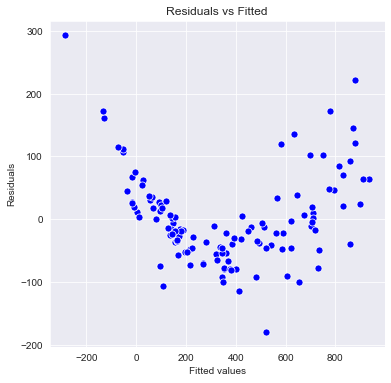

In [14]:
plt.figure(figsize=(6,6))
sns.scatterplot(x = modelo.fittedvalues, y = modelo.resid, color = 'blue', s = 50)
plt.title('Residuals vs Fitted')
plt.ylabel('Residuals')
plt.xlabel('Fitted values')
plt.grid(True)


Con este gráfico podemos ver que los errores no son independientes y tampoco son homocedásticos. A continuación una imagen en la que se explica el termino de homocedasticidad:

<img src = "homocedasticidad.jpg">

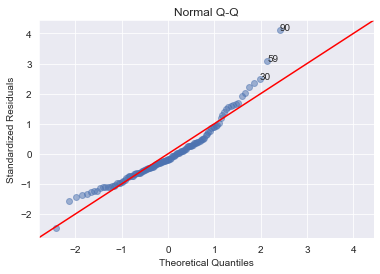

In [15]:

with sns.axes_style('darkgrid'):
    QQ = ProbPlot(modelo.get_influence().resid_studentized_internal)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
    # Anotaciones
    abs_norm_resid = np.flip(np.argsort(np.abs(modelo.get_influence().resid_studentized_internal)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i,
                                    xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                        modelo.get_influence().resid_studentized_internal[i]))
        

Este gráfico nos permite estudiar la normalidad de los residuos. Seguirían una distribución normal si los puntos siguiesen la línea roja. Esto nos esta diciendo que los errores no están distribuidos exactamente como deberían, aunque vamos a darlo por bueno.

Los residuos nos dicen que el modelo no es perfecto, no obstante, vamos a predecir los valores del test y obtener finalmente una medida del error sobre valores desconocidos

In [16]:
y_testeo, x_testeo = dmatrices(formula, test)

predicciones = modelo.predict(x_testeo)

In [17]:
rmse = mean_squared_error(y_testeo, predicciones, squared = False)
print(f"RMSE: {rmse}")

RMSE: 92.75861688982407
